<a href="https://colab.research.google.com/github/SebastianKropp/DisasterDetectionModel/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE 144 Spring 2023 Project

Transformer model for disaster tweet detection.

Steps:

1. Preprocessing: Preprocess the text by tokenizing and converting the text to numerical representations using tokenizer from pretrained model.

2. Model Implementation: Implement a BERT model for detecting disaster tweets.

3. Model Evaluation: Train the model on the preprocessed dataset and evaluate its performance using accuracy, precision, recall, and F1-score. Experiment with different hyperparameters such as learning rate, batch size, and number of epochs to optimize the model's performance.

4. (Optional) Model Interpretation: Analyze the model's predictions by examining the most important features or words that contribute to a disaster or non-disaster tweet. (Optional: Visualize the results using techniques such as word clouds or attention maps).

Datasets: 

- Kaggle dataset: https://www.kaggle.com/competitions/nlp-getting-started/data
- Additional: https://www.kaggle.com/datasets/vstepanenko/disaster-tweets?select=tweets.csv

## Dependencies and Imports

In [1]:
%%capture
!pip install transformers
!pip install sentencepiece sacremoses importlib_metadata
!pip install datasets

In [2]:
import pandas as pd
import random
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from datasets import load_dataset
import math
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

## Preprocessing
Preprocess the text by tokenizing and converting the text to numerical representations.

### Load Dataset

In [135]:
# Load the datasets from CSV
dataset_path = 'preprocessed_train.csv'
dataset = pd.read_csv(dataset_path)
dataset_add = pd.read_csv('additional_tweets.csv')

print(dataset['keyword'][:3])
num_unique_keywords = dataset['keyword'].nunique()
print("Number of unique keywords:", num_unique_keywords)

# Select features to use
feature_list = ['negative']
# for keywords probably have to do one hot encoding first since current code doesn't work with str values

# Combine into a feature matrix
features = dataset[feature_list].values
num_extra_features = features.shape[1]

# ----- Use only preprocessed dataset -----

# Split the dataset into train and test sets
train_texts, test_texts, train_labels, test_labels, train_features, test_features, train_keywords, test_keywords = train_test_split(dataset['text'], dataset['target'], features, dataset['keyword'], test_size=0.2, random_state=42)

# ----- Use additional dataset without sentiment and sarcasm -----

# Get additional columns not present in dataset_add
extra_columns = ['neutral', 'positive', 'negative', 'sarcastic', 'not_sarcastic']

# Add missing columns to dataset and set their values to 0
for column in extra_columns:
    dataset_add[column] = 0

# Combine the additional columns into a feature matrix
features_dummy = dataset_add[feature_list].values

# Split the additional dataset into train and test sets
# Set test_size to very small value if you want to test models on same data and then use testloader for both evaluations (this is necessary if you want to combine results)
test_size = 1e-5
train_texts_add, test_texts_add, train_labels_add, test_labels_add, train_features_add, test_features_add, train_keywords_add, test_keywords_add = train_test_split(dataset_add['text'], dataset_add['target'], features_dummy, dataset_add['keyword'], test_size=test_size, random_state=42)

# Combine the train and test sets from both datasets
train_texts_comb = pd.concat([train_texts, train_texts_add], ignore_index=True)
train_labels_comb = pd.concat([train_labels, train_labels_add], ignore_index=True)
train_features_comb = np.concatenate([train_features, train_features_add], axis=0)
train_keywords_comb = pd.concat([train_keywords, train_keywords_add], ignore_index=True)

test_texts_comb = pd.concat([test_texts, test_texts_add], ignore_index=True)
test_labels_comb = pd.concat([test_labels, test_labels_add], ignore_index=True)
test_features_comb = np.concatenate([test_features, test_features_add], axis=0)
test_keywords_comb = pd.concat([test_keywords, test_keywords_add], ignore_index=True)

# Specify the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

0    NaN
1    NaN
2    NaN
Name: keyword, dtype: object
Number of unique keywords: 221


### Tokenization

In [53]:
def preprocess(texts, tokenizer, features=None, keywords=None):
  texts = texts.tolist() if isinstance(texts, pd.Series) else texts  # Convert to list if needed

  encoded_inputs = tokenizer(
    texts,
    padding='longest',
    truncation=True,
    max_length=512,
    return_tensors='pt',
    add_special_tokens=True
  )
  input_ids = encoded_inputs['input_ids'].to(device)
  attention_masks = encoded_inputs['attention_mask'].to(device)

  if not features is None:

    # Encode the keyword column
    keyword_tokens = []
    for keyword in keywords:
        if pd.isnull(keyword):
            keyword_tokens.append(tokenizer.pad_token_id)
        else:
            keyword_tokens.append(tokenizer.encode(keyword, add_special_tokens=False)[0])
    keyword_tokens = torch.tensor(keyword_tokens).unsqueeze(1).to(device)

    features_tensor = torch.tensor(features.tolist()).to(device)
    return input_ids, attention_masks, features_tensor, keyword_tokens

  return input_ids, attention_masks

In [54]:
# Load a pre-trained tokenizer
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [55]:
# Test preprocess()
test = train_texts[:2]
input_ids, attention_masks = preprocess(test, tokenizer)

# Print the first example
print("Text:", test.iloc[0])
print("Tokenized input:", tokenizer.convert_ids_to_tokens(input_ids[0].tolist()))
print("Input IDs:", input_ids[0])
print("Attention Mask:", attention_masks[0])

Text: @organicallyrude @1ROCKSTAR62 #wish Mattingly &amp; Bundy &amp; McGwire were standing on it when it collapsed!
Tokenized input: ['[CLS]', '@', 'organic', '##ally', '##rud', '##e', '@', '1', '##rock', '##star', '##6', '##2', '#', 'wish', 'matt', '##ingly', '&', 'amp', ';', 'bun', '##dy', '&', 'amp', ';', 'mc', '##g', '##wire', 'were', 'standing', 'on', 'it', 'when', 'it', 'collapsed', '!', '[SEP]', '[PAD]']
Input IDs: tensor([  101,  1030,  7554,  3973, 28121,  2063,  1030,  1015, 16901, 14117,
         2575,  2475,  1001,  4299,  4717, 15787,  1004, 23713,  1025, 21122,
         5149,  1004, 23713,  1025, 11338,  2290, 20357,  2020,  3061,  2006,
         2009,  2043,  2009,  7798,   999,   102,     0], device='cuda:0')
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')


### Build DataLoaders

In [136]:
# ----- Build train dataset -----

# Preprocess the text data
train_input_ids, train_attention_masks, train_features_tensor, train_keyword_tokens = preprocess(train_texts, tokenizer, train_features, train_keywords)

num_unique_keywords = len(np.unique(train_keyword_tokens.cpu().numpy()))
print("Number of unique keywords:", num_unique_keywords)

# Convert train_labels to a list, then to a tensor
train_labels_tensor = torch.tensor(train_labels.tolist()).to(device)

# Build train dataset
train_dataset = torch.utils.data.TensorDataset(train_input_ids, train_attention_masks, train_features_tensor, train_keyword_tokens, train_labels_tensor)

# Split the dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# ------ Build test dataset -----

# Preprocess the text data
test_input_ids, test_attention_masks, test_features_tensor, test_keyword_tokens = preprocess(test_texts, tokenizer, test_features, test_keywords)

# Convert train_labels to a list, then to a tensor
test_labels_tensor = torch.tensor(test_labels.tolist()).to(device)

# Build test dataset
test_dataset = torch.utils.data.TensorDataset(test_input_ids, test_attention_masks, test_features_tensor, test_keyword_tokens, test_labels_tensor)

Number of unique keywords: 187


In [137]:
# Define batch size
batch_size = 128

# Build DataLoaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [138]:
# ----- Build train dataset -----

# Preprocess the text data
train_input_ids_comb, train_attention_masks_comb, train_features_tensor_comb, train_keyword_tokens_comb = preprocess(train_texts_comb, tokenizer, train_features_comb, train_keywords_comb)

# Convert train_labels to a list, then to a tensor
train_labels_tensor_comb = torch.tensor(train_labels_comb.tolist()).to(device)

# Build train dataset
train_dataset_comb = torch.utils.data.TensorDataset(train_input_ids_comb, train_attention_masks_comb, train_features_tensor_comb, train_keyword_tokens_comb, train_labels_tensor_comb)

# Split the dataset into train and validation sets
train_size_comb = int(0.8 * len(train_dataset_comb))
val_size_comb = len(train_dataset_comb) - train_size_comb
train_dataset_comb, val_dataset_comb = torch.utils.data.random_split(train_dataset_comb, [train_size_comb, val_size_comb])

# ------ Build test dataset -----

# Preprocess the text data
test_input_ids_comb, test_attention_masks_comb, test_features_tensor_comb, test_keyword_tokens_comb = preprocess(test_texts_comb, tokenizer, test_features_comb, test_keywords_comb)

# Convert train_labels to a list, then to a tensor
test_labels_tensor_comb = torch.tensor(test_labels_comb.tolist()).to(device)

# Build test dataset
test_dataset_comb = torch.utils.data.TensorDataset(test_input_ids_comb, test_attention_masks_comb, test_features_tensor_comb, test_keyword_tokens_comb, test_labels_tensor_comb)

In [139]:
# Define batch size
batch_size_comb = 128

# Build DataLoaders
trainloader_comb = torch.utils.data.DataLoader(train_dataset_comb, batch_size=batch_size, shuffle=True)
testloader_comb = torch.utils.data.DataLoader(test_dataset_comb, batch_size=batch_size, shuffle=False)
valloader_comb = torch.utils.data.DataLoader(val_dataset_comb, batch_size=batch_size, shuffle=False)

## Implementation
Implement model using a pre-trained model.

In [18]:
from transformers import AutoModel

### Custom BERT

In [140]:
%%capture

class CustomBERTOutput:
    def __init__(self, logits, hidden_states):
        self.logits = logits
        self.hidden_states = hidden_states

class CustomBERTModel(nn.Module):
    def __init__(self, model_name, num_labels, hidden_dim, dropout_rate):
        super(CustomBERTModel, self).__init__()

        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = torch.nn.Sequential(
            nn.Linear(self.bert.config.hidden_size + num_extra_features + 1, hidden_dim),
            nn.Tanh(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_labels)
        )

    def forward(self, input_ids, attention_mask, features, keyword_tokens):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
            
        combined_output = torch.cat((pooled_output, features, keyword_tokens), dim=1)

        logits = self.classifier(combined_output)

        return CustomBERTOutput(logits=logits, hidden_states=outputs.hidden_states)

# Number of labels
num_labels = 2

# Load the custom pre-trained model
hidden_dim = 1024
dropout_rate = 0.1
model1 = CustomBERTModel(model_name, num_labels, hidden_dim, dropout_rate)

model1.to(device)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### BERT

In [160]:
%%capture

# Number of labels
num_labels = 2

# Load the pre-trained model
model2 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Download model and configuration from S3 and cache.
config = AutoConfig.from_pretrained(model_name)
last_state_dim = config.hidden_size

# Replace the pre-trained head with a new one.
model2.classifier = torch.nn.Linear(last_state_dim, num_labels)

hidden_dim = 1024
dropout_rate = 0.1
#model2.classifier = torch.nn.Sequential(
#    nn.Linear(last_state_dim, hidden_dim),
#    nn.Tanh(),
#    nn.Dropout(dropout_rate),
#    nn.Linear(hidden_dim, num_labels)
#)

model2.to(device)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

## Training and Evaluation
Train the model on the preprocessed dataset and evaluate its performance using accuracy, precision, recall, and F1-score. Experiment with different hyperparameters such as learning rate, batch size, and number of epochs to optimize the model's performance.

### Train

In [28]:
def train_model(model, optimizer, criterion, trainloader, valloader, use_features=False):
  model.train()

  losses = []  # List to store the loss after each epoch
  accuracies = []
  val_accuracies = []
  best_val_accuracy = -1  # Initialize the best validation accuracy
  early_stopping_counter = 0  # Counter for early stopping
    
  for epoch in range(epochs):
      running_loss = 0.0
        
      for batch in trainloader:
          input_ids, attention_masks, features, keyword_tokens, labels = batch
          input_ids, attention_masks, features, keyword_tokens, labels = input_ids.to(device), attention_masks.to(device), features.to(device), keyword_tokens.to(device), labels.to(device)
            
          optimizer.zero_grad()
            
          # Forward pass
          if use_features:
            outputs = model(input_ids=input_ids, attention_mask=attention_masks, features=features, keyword_tokens=keyword_tokens)
          else: 
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)

          if hasattr(outputs, 'logits'):
              # BERT model
              logits = outputs.logits.to(device)
              loss = criterion(logits, labels)
          else:
              # GPT model   
              logits = outputs.last_hidden_state[:, 0, :].to(device)        
              loss = criterion(logits, labels.long())

          # Backward pass and optimization
          loss.backward()
          #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

          optimizer.step()
          #scheduler.step()
          losses.append(loss.detach().cpu().numpy())

          # Calculate accuracy
          _, predicted_labels = torch.max(logits, dim=1)
          batch_accuracy = (predicted_labels == labels).sum().item() / labels.size(0)
          accuracies.append(batch_accuracy)

          # Uncomment to calculate validation accuracy (takes more time)
          val_accuracy, _, _, _, _ = evaluate_model(model, valloader, False, use_features=use_features)
          val_accuracies.append(val_accuracy)

      # Check if the current validation accuracy is better than the previous best
      if val_accuracy > best_val_accuracy:
          best_val_accuracy = val_accuracy
          early_stopping_counter = 0  # Reset the counter
      else:
          early_stopping_counter += 1  # Increment the counter

      print('Train Epoch: {}\tLoss: {:.6f}\tTrain Accuracy: {:.4f}\tValidation Accuracy: {:.4f}'.format(
        epoch, loss.item(), batch_accuracy, val_accuracy))
      #print('Train Epoch: {}\tLoss: {:.6f}\tTrain Accuracy: {:.4f}'.format(
      #  epoch, loss.item(), batch_accuracy))

      # Check if early stopping criterion is met
      if early_stopping_counter >= patience:
        print("Early stopping triggered. No improvement in validation accuracy for {} epochs.".format(patience))
        break

  return losses, accuracies, val_accuracies

### Evaluate

In [29]:
def evaluate_model(model, dataloader, is_test=True, use_features=False):
    model.eval()
    predictions = []
    true_labels = []
    predicted_probs = []
    input_ids_list = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_masks, features, keyword_tokens, labels = batch
            input_ids, attention_masks, features, keyword_tokens, labels = input_ids.to(device), attention_masks.to(device), features.to(device), keyword_tokens.to(device), labels.to(device)

            if use_features:
              outputs = model(input_ids=input_ids, attention_mask=attention_masks, features=features, keyword_tokens=keyword_tokens)
            else:
              outputs = model(input_ids=input_ids, attention_mask=attention_masks)

            if hasattr(outputs, 'logits'):
                # BERT model
                logits = outputs.logits.to(device)
            else:
                # GPT model
                #hidden_states = outputs.last_hidden_state
                #logits = model.classifier(hidden_states)
                logits = outputs.last_hidden_state[:, 0, :].to(device)

            _, predicted_labels = torch.max(logits, dim=1)
            predicted_prob = torch.softmax(logits, dim=1)

            predictions.extend(predicted_labels.cpu().tolist())
            #predictions.extend(F.one_hot(predicted_labels, num_labels).float().cpu().tolist())
            true_labels.extend(labels.cpu().tolist())
            #true_labels.extend(F.one_hot(labels, num_labels).float().cpu().tolist())
            predicted_probs.extend(predicted_prob.cpu().tolist())  # Assuming class 1 is the positive class
            input_ids_list.extend(input_ids.cpu().tolist())

    predicted_probs = np.array(predicted_probs)

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)

    if is_test:
      print("Evaluation on test set:")
      precision = precision_score(true_labels, predictions, average='macro')
      recall = recall_score(true_labels, predictions, average='macro')
      f1 = f1_score(true_labels, predictions, average='macro')
      return accuracy, precision, recall, f1, true_labels, predictions, predicted_probs, input_ids_list

    else:
        return accuracy, true_labels, predictions, predicted_probs, input_ids_list

### Hyperparameters

In [161]:
# Define learning rate and number of epochs
learning_rate1 = 1e-5
learning_rate2 = 1e-5
epochs = 50
patience = 2

# Define the optimizer and criterion
optimizer1 = optim.AdamW(model1.parameters(), lr=learning_rate1) # best learning rate: 1e-5, avg result: ~80%
#optimizer1 = optim.RMSprop(model1.parameters(), lr=learning_rate) # best learning rate: 1e-5, avg result: ~81% accuracy
#optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate) # best learning rate: 1e-5, avg result: ~80% accuracy

optimizer2 = optim.AdamW(model2.parameters(), lr=learning_rate2) # best learning rate: 1e-5, avg result: ~80%
#optimizer2 = optim.RMSprop(model2.parameters(), lr=learning_rate) # best learning rate: 1e-5, avg result: ~81% accuracy
#optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate) # best learning rate: 1e-5, avg result: ~80% accuracy

criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class classification

# Define the scheduler to adjust learning rate
#scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(trainloader) * epochs)

### Train and evaluate models

In [145]:
# Train model1
losses1, accuracies1, val_accuracies1 = train_model(model1, optimizer1, criterion, trainloader, valloader, use_features=True)

Train Epoch: 0	Loss: 0.710042	Train Accuracy: 0.3333	Validation Accuracy: 0.5895
Train Epoch: 1	Loss: 0.699543	Train Accuracy: 0.5000	Validation Accuracy: 0.5895
Train Epoch: 2	Loss: 0.614147	Train Accuracy: 0.5000	Validation Accuracy: 0.7340
Train Epoch: 3	Loss: 0.556466	Train Accuracy: 0.8333	Validation Accuracy: 0.7939
Train Epoch: 4	Loss: 0.608373	Train Accuracy: 0.8333	Validation Accuracy: 0.8005
Train Epoch: 5	Loss: 0.555713	Train Accuracy: 1.0000	Validation Accuracy: 0.8013
Train Epoch: 6	Loss: 0.520208	Train Accuracy: 1.0000	Validation Accuracy: 0.8062
Train Epoch: 7	Loss: 0.498280	Train Accuracy: 0.8333	Validation Accuracy: 0.8038
Train Epoch: 8	Loss: 0.492172	Train Accuracy: 0.8333	Validation Accuracy: 0.8079
Train Epoch: 9	Loss: 0.448566	Train Accuracy: 1.0000	Validation Accuracy: 0.8038
Train Epoch: 10	Loss: 0.542848	Train Accuracy: 0.8333	Validation Accuracy: 0.8046
Early stopping triggered. No improvement in validation accuracy for 2 epochs.


In [163]:
# Train model2
losses2, accuracies2, val_accuracies2 = train_model(model2, optimizer2, criterion, trainloader_comb, valloader_comb)

Train Epoch: 0	Loss: 0.416344	Train Accuracy: 0.7692	Validation Accuracy: 0.7360
Train Epoch: 1	Loss: 0.562974	Train Accuracy: 0.6923	Validation Accuracy: 0.8153
Train Epoch: 2	Loss: 0.448174	Train Accuracy: 0.7692	Validation Accuracy: 0.8368
Train Epoch: 3	Loss: 0.522171	Train Accuracy: 0.8462	Validation Accuracy: 0.8491
Train Epoch: 4	Loss: 0.225299	Train Accuracy: 0.9231	Validation Accuracy: 0.8519
Train Epoch: 5	Loss: 0.236265	Train Accuracy: 0.9231	Validation Accuracy: 0.8565
Train Epoch: 6	Loss: 0.263640	Train Accuracy: 0.8462	Validation Accuracy: 0.8591
Train Epoch: 7	Loss: 0.324599	Train Accuracy: 0.6923	Validation Accuracy: 0.8631
Train Epoch: 8	Loss: 0.298053	Train Accuracy: 0.9231	Validation Accuracy: 0.8597
Train Epoch: 9	Loss: 0.180059	Train Accuracy: 0.9231	Validation Accuracy: 0.8494
Early stopping triggered. No improvement in validation accuracy for 2 epochs.


In [164]:
# Evaluate model1
accuracy1, precision1, recall1, f11, true_labels1, predictions1, predicted_probs1, input_ids_list1 = evaluate_model(model1, testloader, use_features=True)

# Print results
print(f"Accuracy: {accuracy1:.4f}")
print(f"Precision: {precision1:.4f}")
print(f"Recall: {recall1:.4f}")
print(f"F1 Score: {f11:.4f}")

Evaluation on test set:
Accuracy: 0.8042
Precision: 0.8009
Recall: 0.7982
F1 Score: 0.7994


In [165]:
# Evaluate model2
accuracy2, precision2, recall2, f12, true_labels2, predictions2, predicted_probs2, input_ids_list2 = evaluate_model(model2, testloader)

# Print results
print(f"Accuracy: {accuracy2:.4f}")
print(f"Precision: {precision2:.4f}")
print(f"Recall: {recall2:.4f}")
print(f"F1 Score: {f12:.4f}")

Evaluation on test set:
Accuracy: 0.8121
Precision: 0.8110
Recall: 0.8034
F1 Score: 0.8062


## Visualizations - Training

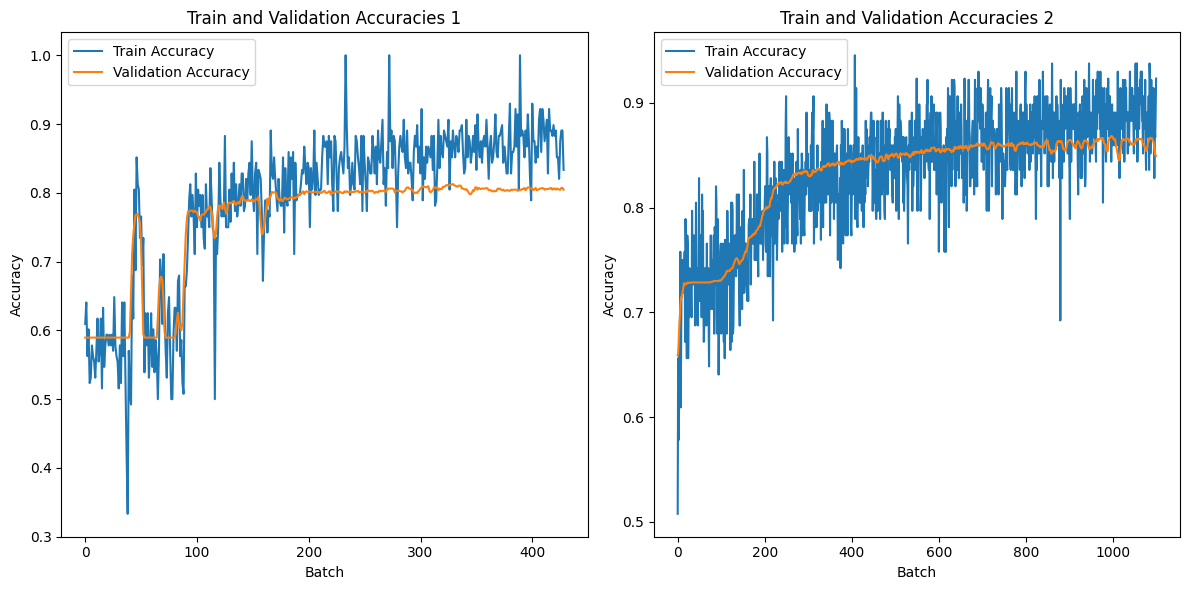

In [166]:
def plot_train_val_accuracies(accuracies, val_accuracies, ax):
    ax.plot(accuracies, label='Train Accuracy')
    ax.plot(val_accuracies, label='Validation Accuracy')
    ax.set(xlabel='Batch', ylabel='Accuracy')
    ax.legend()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first set of accuracies
plot_train_val_accuracies(accuracies1, val_accuracies1, axs[0])
axs[0].set(title='Train and Validation Accuracies 1')

# Plot the second set of accuracies
plot_train_val_accuracies(accuracies2, val_accuracies2, axs[1])
axs[1].set(title='Train and Validation Accuracies 2')

# Adjust the layout to avoid overlapping titles and labels
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
def plot_train_val_accuracies_individual(accuracies, val_accuracies):
  plt.plot(accuracies, label='Train Accuracy')
  plt.plot(val_accuracies, label='Validation Accuracy')
  plt.xlabel('Batch')
  plt.ylabel('Accuracy')
  plt.title('Train and Validation Accuracies')
  plt.legend()
  plt.show()

plot_train_val_accuracies_individual(accuracies1, val_accuracies1)
plot_train_val_accuracies_individual(accuracies2, val_accuracies2)

In [ ]:
def plot_metric(metric, ax):
    ax.plot(range(0, len(metric)), metric)
    ax.set(xlabel='Batch', ylabel='Value')

# Create a figure with two subplots for losses
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first set of losses
plot_metric(losses1, axs[0])
axs[0].set(title='Losses 1')

# Plot the second set of losses
plot_metric(losses2, axs[1])
axs[1].set(title='Losses 2')

plt.tight_layout()
plt.show()

# Create a figure with two subplots for accuracies
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first set of accuracies
plot_metric(accuracies1, axs[0])
axs[0].set(title='Accuracies 1')

# Plot the second set of accuracies
plot_metric(accuracies2, axs[1])
axs[1].set(title='Accuracies 2')

plt.tight_layout()
plt.show()

In [ ]:
def plot_metric_individual(metric):
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(range(0, len(metric)), metric)

plot_metric_individual(losses1)
plot_metric_individual(losses2)
plot_metric_individual(accuracies1)
plot_metric_individual(accuracies2)

## Visualizations - Evaluation

In [168]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
import seaborn as sns

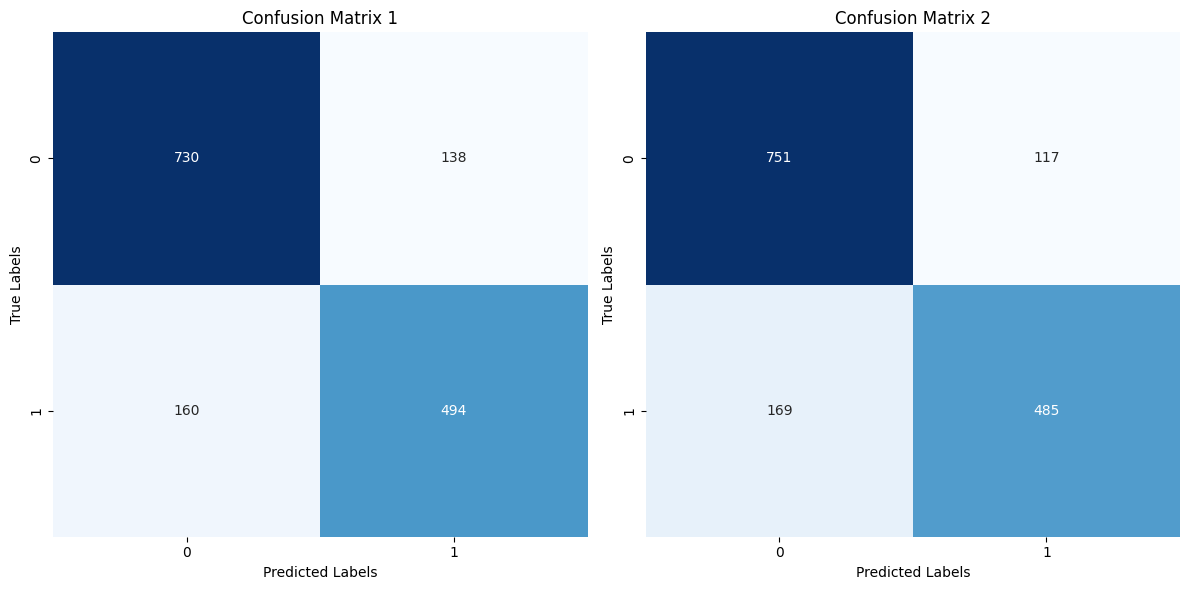

In [169]:
def plot_confusion_matrix(true_labels, predicted_labels, ax):
    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Create a heatmap for the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)

    # Set axis labels and title
    ax.set(xlabel='Predicted Labels', ylabel='True Labels')

# Create a figure with two subplots for confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first confusion matrix
plot_confusion_matrix(true_labels1, predictions1, axs[0])
axs[0].set(title='Confusion Matrix 1')

# Plot the second confusion matrix
plot_confusion_matrix(true_labels2, predictions2, axs[1])
axs[1].set(title='Confusion Matrix 2')

plt.tight_layout()
plt.show()

In [ ]:
def plot_confusion_matrix_individual(true_labels, predicted_labels):
    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Create a heatmap for the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)

    # Set axis labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

plot_confusion_matrix_individual(true_labels1, predictions1)
plot_confusion_matrix_individual(true_labels2, predictions2)

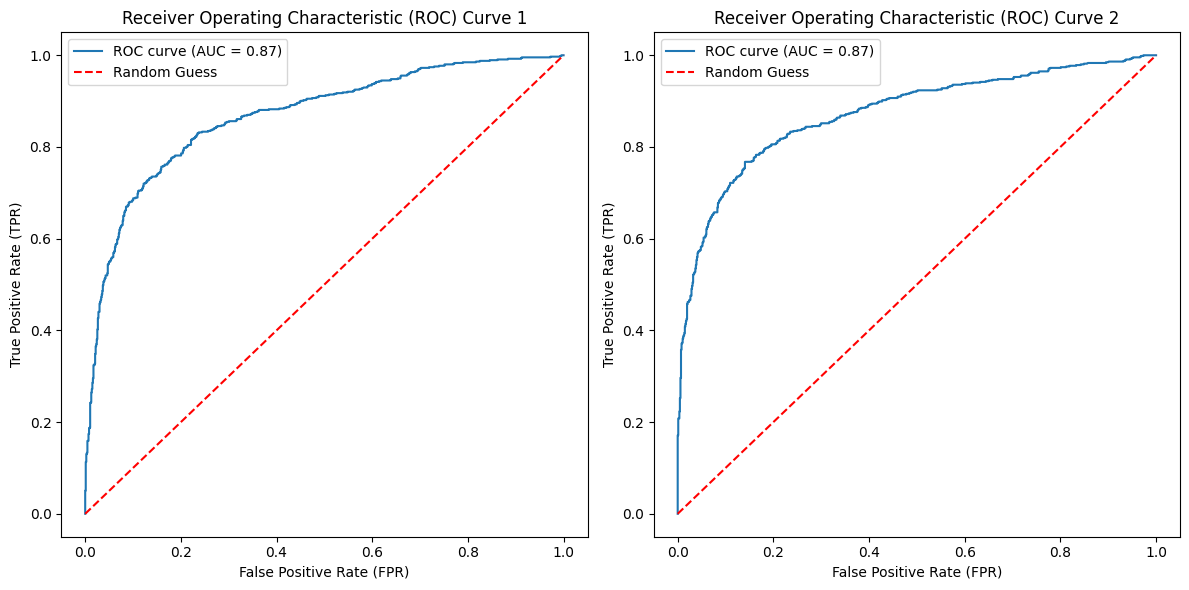

In [170]:
def plot_roc_curve(true_labels, predicted_probs, ax):
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs[:, 1])
    auc = roc_auc_score(true_labels, predicted_probs[:, 1])

    ax.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
    ax.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
    ax.set(xlabel='False Positive Rate (FPR)', ylabel='True Positive Rate (TPR)')
    ax.legend()

# Create a figure with two subplots for ROC curves
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first ROC curve
plot_roc_curve(true_labels1, predicted_probs1, axs[0])
axs[0].set(title='Receiver Operating Characteristic (ROC) Curve 1')

# Plot the second ROC curve
plot_roc_curve(true_labels2, predicted_probs2, axs[1])
axs[1].set(title='Receiver Operating Characteristic (ROC) Curve 2')

plt.tight_layout()
plt.show()

In [ ]:
def plot_roc_curve_individual(true_labels, predicted_probs):
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs[:, 1])
    auc = roc_auc_score(true_labels, predicted_probs[:, 1])

    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_curve_individual(true_labels1, predicted_probs1)
plot_roc_curve_individual(true_labels2, predicted_probs2)

## Interpretation

In [ ]:
def find_most_significant_words(input_ids_list, predicted_probs):
    token_scores = {}

    # Aggregate the predicted probabilities for each token across examples
    for example_probs in predicted_probs:
        for token_index, prob_positive_class in enumerate(example_probs):
            if token_index not in token_scores:
                token_scores[token_index] = prob_positive_class
            else:
                token_scores[token_index] += prob_positive_class

    # Sort the token scores in descending order
    sorted_scores = sorted(token_scores.items(), key=lambda x: x[1], reverse=True)

    # Get the top 10 most significant words
    top_10_tokens = [token_index for token_index, _ in sorted_scores[:10]]
    top_10_words = [tokenizer.convert_ids_to_tokens(input_ids[token_index]) for token_index in top_10_tokens]

    return top_10_words

In [ ]:
top_words = find_most_significant_words(input_ids_list, predicted_probs)
print(top_words)

## GPT

In [ ]:
from transformers import GPT2Model, GPT2Tokenizer, GPT2Config, OpenAIGPTTokenizer 

In [ ]:
# Load the pre-trained model
model_name_gpt = 'distilgpt2'
#model_name_gpt = 'openai-gpt'
model_config_gpt = GPT2Config.from_pretrained(model_name_gpt)

# Load pre-trained tokenizer
tokenizer_gpt = GPT2Tokenizer.from_pretrained(model_name_gpt)
#tokenizer_gpt = OpenAIGPTTokenizer.from_pretrained(model_name_gpt)

tokenizer_gpt.add_special_tokens({'pad_token': '[PAD]'})

model_config_gpt.vocab_size = len(tokenizer_gpt)

gpt = GPT2Model.from_pretrained(model_name_gpt, config=model_config_gpt, ignore_mismatched_sizes=True)

# Replace the pre-trained head with a new one
last_state_dim_gpt = model_config_gpt.hidden_size
gpt.classifier = nn.Linear(last_state_dim_gpt, num_labels)

# Move the model to the appropriate device
gpt.to(device)

Some weights of GPT2Model were not initialized from the model checkpoint at distilgpt2 and are newly initialized because the shapes did not match:
- transformer.wte.weight: found shape torch.Size([50257, 768]) in the checkpoint and torch.Size([50258, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Build train dataset (not using combined dataset bc this is already taking really long)
train_input_ids_gpt, train_attention_masks_gpt, train_features_tensor_gpt = preprocess(train_texts, tokenizer_gpt, train_features)
train_labels_gpt = torch.tensor(train_labels.tolist()).to(device)
train_dataset_gpt = torch.utils.data.TensorDataset(train_input_ids_gpt, train_attention_masks_gpt, train_features_tensor_gpt, train_labels_gpt)

# Split the dataset into train and validation sets
train_size_gpt = int(0.8 * len(train_dataset_gpt))
val_size_gpt = len(train_dataset_gpt) - train_size_gpt
train_dataset_gpt, val_dataset_gpt = torch.utils.data.random_split(train_dataset_gpt, [train_size_gpt, val_size_gpt])

# Build test dataset
test_input_ids_gpt, test_attention_masks_gpt, test_features_tensor_gpt = preprocess(test_texts, tokenizer_gpt, test_features)
test_labels_gpt = torch.tensor(test_labels.tolist()).to(device)
test_dataset_gpt = torch.utils.data.TensorDataset(test_input_ids_gpt, test_attention_masks_gpt, test_features_tensor_gpt, test_labels_gpt)

In [ ]:
# Define batch size
batch_size_gpt = 32

# Build DataLoaders
trainloader_gpt = torch.utils.data.DataLoader(train_dataset_gpt, batch_size=batch_size_gpt, shuffle=True)
testloader_gpt = torch.utils.data.DataLoader(test_dataset_gpt, batch_size=batch_size_gpt, shuffle=False)
valloader_gpt = torch.utils.data.DataLoader(val_dataset_gpt, batch_size=batch_size_gpt, shuffle=False)

In [ ]:
# Define learning rate and number of epochs
learning_rate_gpt = 1e-2
epochs_gpt = 50
patience_gpt = 2

# Define the optimizer and criterion
optimizer_gpt = optim.AdamW(gpt.parameters(), lr=learning_rate_gpt)
criterion_gpt = nn.CrossEntropyLoss()

In [ ]:
# Train model
losses_gpt, accuracies_gpt, val_accuracies_gpt = train_model(gpt, optimizer_gpt, criterion_gpt, trainloader_gpt, valloader_gpt)

Train Epoch: 0	Loss: 0.484405	Train Accuracy: 0.8333	Validation Accuracy: 0.6043
Train Epoch: 1	Loss: 0.584627	Train Accuracy: 0.5000	Validation Accuracy: 0.6420
Train Epoch: 2	Loss: 0.562023	Train Accuracy: 0.5000	Validation Accuracy: 0.6117
Train Epoch: 3	Loss: 0.879112	Train Accuracy: 0.3333	Validation Accuracy: 0.6322
Early stopping triggered. No improvement in validation accuracy for 2 epochs.


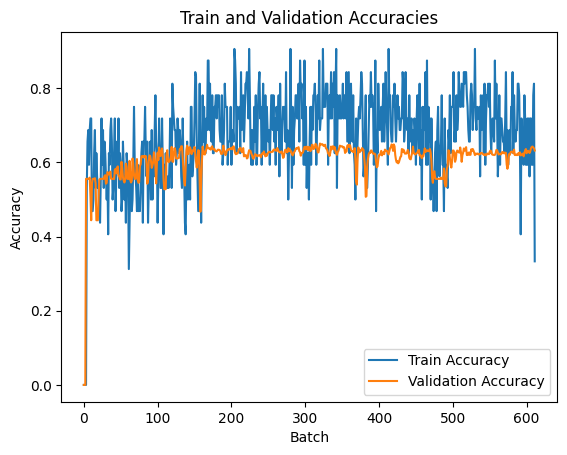

In [ ]:
# Compare train and validation accuracy during training
plot_train_val_accuracies_individual(accuracies_gpt, val_accuracies_gpt)

In [ ]:
# Create a figure with two subplots for losses
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first set of losses
plot_metric(losses_gpt, axs[0])
axs[0].set(title='Losses GPT')

# Plot the second set of losses
plot_metric(accuracies_gpt, axs[1])
axs[1].set(title='Accuracies GPT')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate model
accuracy_gpt, precision_gpt, recall_gpt, f1_gpt, true_labels_gpt, predictions_gpt, predicted_probs_gpt, input_ids_list_gpt = evaluate_model(gpt, testloader_gpt)

# Print results
print(f"Accuracy: {accuracy_gpt:.4f}")
print(f"Precision: {precision_gpt:.4f}")
print(f"Recall: {recall_gpt:.4f}")
print(f"F1 Score: {f1_gpt:.4f}")

Evaluation on test set:
Accuracy: 0.6367
Precision: 0.6272
Recall: 0.6164
F1 Score: 0.6163


## Logistic Regression

In [70]:
import re
from sklearn.preprocessing import StandardScaler

In [131]:
logreg = LogisticRegression(max_iter=8000, solver='lbfgs')

In [72]:
def extract_features(text):
    # Mean word length
    words = text.split()
    mean_word_length = sum(len(word) for word in words) / len(words)

    # Character count
    character_count = len(text)

    # Punctuation count
    punctuation_count = len(re.findall(r'[^\w\s]', text))

    return mean_word_length, character_count, punctuation_count

In [132]:
# Apply feature extraction to the train and test texts
train_features_text = [extract_features(text) for text in train_texts]
test_features_text = [extract_features(text) for text in test_texts]

# Convert the features to a NumPy array and standardize the values if needed
train_features_text = np.array(train_features_text)
test_features_text = np.array(test_features_text)

# Concatenate the text features and additional features
train_features_all = np.concatenate((train_features_text, train_features), axis=1)
test_features_all = np.concatenate((test_features_text, test_features), axis=1)

# add one hot encoded keywords

# Scale the input features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_all)
test_features_scaled = scaler.transform(test_features_all)

In [85]:
for i in range(2):
    print("Train Feature", i + 1)
    print(train_features_all[i])

Train Feature 1
[6.40000000e+00 1.10000000e+02 8.00000000e+00 4.03897732e-01
 7.37980679e-02 5.22304177e-01 9.33222234e-01 6.67777210e-02]
Train Feature 2
[6.83333333e+00 1.40000000e+02 8.00000000e+00 2.27039933e-01
 8.10099244e-02 6.91950202e-01 9.64934170e-01 3.50657664e-02]


In [133]:
# Train logistic regression model
logreg.fit(train_features_scaled, train_labels)

# Make predictions using logistic regression model
logreg_predictions = logreg.predict(test_features_scaled)

# Evaluate logistic regression model
logreg_accuracy = accuracy_score(test_labels, logreg_predictions)
print("Logistic Regression Accuracy:", logreg_accuracy)

Logistic Regression Accuracy: 0.6471747700394218


## Combine results

In [171]:
# Average the predicted probabilities from BERT and logistic regression
logreg_probs = logreg.predict_proba(test_features_all)[:, 1]  # Extract the probabilities of the positive class
logreg_probs = logreg_probs.reshape(-1, 1)  # Reshape to match the shape of BERT's predicted probabilities

combined_probs = (predicted_probs2 + logreg_probs + predicted_probs1) / 3

# Choose the class with the highest average probability
combined_predictions = np.argmax(combined_probs, axis=1)

# Calculate the accuracy of the combined predictions
combined_accuracy = accuracy_score(test_labels, combined_predictions)

print('Combined Model Accuracy: {:.4f}'.format(combined_accuracy))

Combined Model Accuracy: 0.8285


## Predict Disaster or Not

Use trained model to predict if a tweet is about a disaster or not.

In [ ]:
def predict_disaster_TA(texts, model, tokenizer, features=None):
  model.eval() # Set the model to evaluation mode

  if features is None:
    input_ids, attention_mask = preprocess(texts, tokenizer)
  else:
    input_ids, attention_mask, features_tensor = preprocess(texts, tokenizer, features)

  with torch.no_grad():
    if features is None:
      outputs = model(input_ids, attention_mask=attention_mask) # Get the model outputs
    else:
      outputs = model(input_ids, attention_mask=attention_mask, features=features_tensor)
    logits = outputs.logits # Get the logits from the model outputs
    probabilities = F.softmax(logits, dim=1)
    disasters = torch.argmax(probabilities, dim=1).squeeze()

  return disasters, probabilities

In [ ]:
# Call the predict_sentiment_TA function
text = "Just happened a terrible car crash"
neutral = 0.057
positive = 0.0098
negative = 0.933
sarcastic = 0.92
not_sarcastic = 1 - sarcastic
#features = [neutral, positive, negative, sarcastic, not_sarcastic]
features = np.array([neutral, positive, negative, sarcastic, not_sarcastic])
features = features.reshape(1, -1)  # Reshape to (1, 5)
disaster1, probabilities1 = predict_disaster_TA(text, model1, tokenizer, features)
disaster2, probabilities2 = predict_disaster_TA(text, model2, tokenizer)

print(f"Model 1")
print(f"Disaster: {disaster1}")
print(f"Probabilities: {probabilities1}")

print(f"Model 2")
print(f"Disaster: {disaster2}")
print(f"Probabilities: {probabilities2}")

Model 1
Disaster: 1
Probabilities: tensor([[0.2781, 0.7219]], device='cuda:0')
Model 2
Disaster: 1
Probabilities: tensor([[0.2629, 0.7371]], device='cuda:0')
